## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

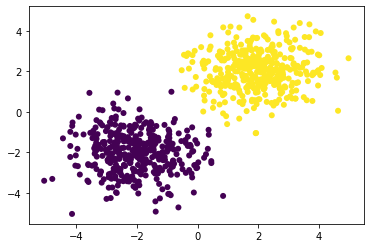

In [2]:
# Generate some data
N = 400

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [3]:
# (re-)load layers
%run modules.ipynb

(1, 2, 3, 3) (1, 2, 2, 2)
(1, 2, 3, 3) (1, 2, 2, 3) (1, 2, 7, 2)


In [4]:
# net = Sequential()
# net.add(Linear(2, 4))
# net.add(LogSoftMax())

# criterion = ClassNLLCriterion()
criterion = ClassNLLCriterionUnstable()
#print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 100))
net.add(SoftPlus())
net.add(Linear(100, 2))
net.add(SoftMax())

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'beta1': 0.3,  'beta2': 0.3,  'epsilon': 0.01}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        print(i)
        # Update weights
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [7]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [8]:
# Your code goes here. ################################################
ohe = np.eye(10)
y_train = ohe[y_train]
y_val = ohe[y_val]
y_test = ohe[y_test]

X_train = X_train.reshape((X_train.shape[0], 28*28))
X_val = X_val.reshape((X_val.shape[0], 28*28))
X_test = X_test.reshape((X_test.shape[0], 28*28))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [9]:
criterion = ClassNLLCriterion()

In [10]:
def loop_epoch(net, X, Y, batch_size, optimizer = None, optimizer_config = None, optimizer_state = None, is_val = False):
    loss_history = []
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        if not is_val:
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            # Update weights
            optimizer(net.getParameters(), 
                      net.getGradParameters(), 
                      optimizer_config,
                      optimizer_state)      
        
        loss_history.append(loss)
    return loss_history

def loop(net, data_train, data_test, optimizer_config, optimizer_state,
         n_epoch = 10, batch_size = 128, is_val = False, opt_type = 'adam'):
    
    criterion = ClassNLLCriterion()
    plot_title = 'Validation loss' if is_val else 'Training loss'
    optimizers = {'adam': adam_optimizer, 'momentum': sgd_momentum}
    optimizer = optimizers[opt_type]
    
    X, Y = data_train
    X_val, Y_val = data_test
    loss_val_history = []
    for i in range(n_epoch):
        loss_history = loop_epoch(net, X, Y, batch_size, optimizer, optimizer_config, optimizer_state)
        loss_val = loop_epoch(net, X_val, Y_val, batch_size, optimizer = optimizer, is_val = True)
        loss_val_mean = sum(loss_val)/len(loss_val)
        loss_val_history.append(loss_val_mean)
        
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title(plot_title)
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()
        
    return loss_val_history

def training_process(net, data_train, data_test, optimizer_config, optimizer_state, opt_type = 'adam'):
    loss_val_history = loop(net, data_train, data_test, optimizer_config, optimizer_state, opt_type = opt_type)
    return loss_val_history

In [11]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-3, 'beta1': 0.9,  'beta2': 0.999,  'epsilon': 1.e-08}

In [12]:
# Your code goes here. ################################################
def analyzation(bn = True, opt_type = 'adam', optimizer_config = optimizer_config):
    act_keys = ['ReLU', 'ELU', 'LeakyReLU', 'SoftPlus']
    activations = {'ReLU': ReLU, 'ELU': ELU, 'LeakyReLU': LeakyReLU, 'SoftPlus': SoftPlus}
    act_losses = dict.fromkeys(act_keys)
    for cur_act in act_keys:
        in_features = X_train.shape[-1]
        features = [in_features, 24*24, 20*20, 14*14, 10]
        net = Sequential()
        for i in range(1, len(features)):
            net.add(Linear(features[i-1], features[i]))
            if bn:
                net.add(BatchNormalization())
                net.add(ChannelwiseScaling(features[i]))
            if i != len(features) - 1:
                net.add(activations[cur_act]())
        net.add(LogSoftMax())
        
        optimizer_state = {}
        act_loss = training_process(net, (X_train, y_train), (X_val, y_val), optimizer_config, optimizer_state, opt_type = opt_type)
        act_losses[cur_act] = act_loss
    return act_losses

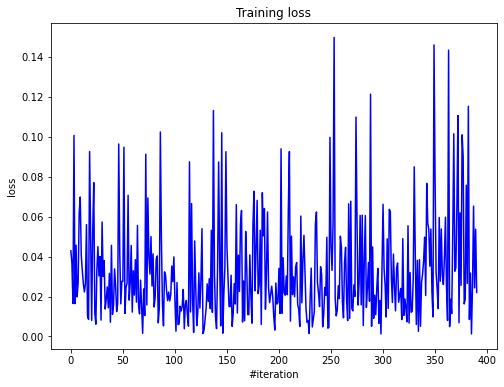

In [13]:
losses_with_bn = analyzation()
losses_without_bn = analyzation(False)

In [15]:
import pickle

In [16]:
with open('losses_without_bn.pickle', 'wb') as fp:
    pickle.dump(losses_without_bn, fp)
    
with open('losses_with_bn.pickle', 'wb') as fp:
    pickle.dump(losses_with_bn, fp)

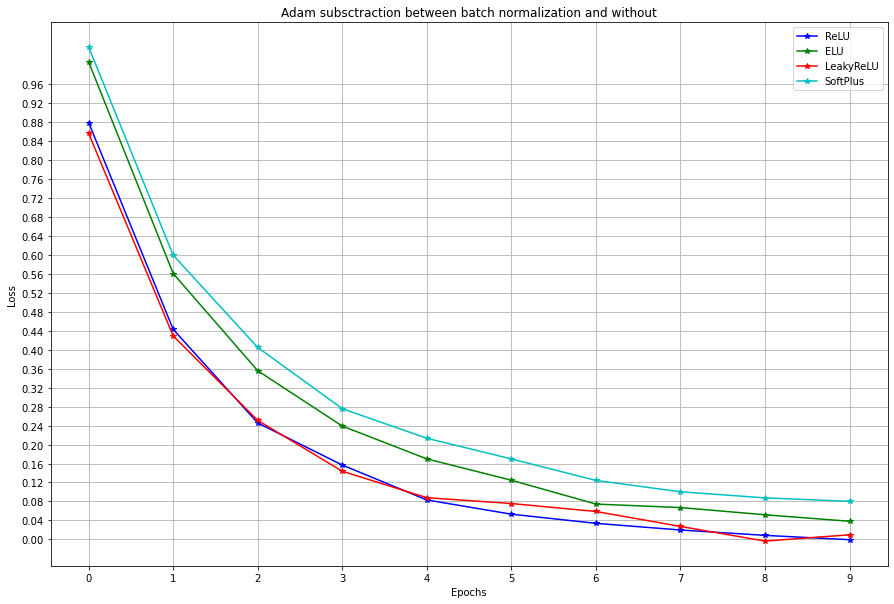

In [21]:
fig, ax = plt.subplots(figsize = (15, 10))
colors =  ['b', 'g', 'r', 'c']
colors_bn = ['m', 'y', 'k', 'w']
keys = losses_without_bn.keys()

for key, c in zip(keys, range(0, len(colors))):
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    y = np.array(losses_with_bn[key]) - np.array(losses_without_bn[key]) 
    ax.plot(y, f'{colors[c]}*-', label = key)

ax.set_title('Adam subsctraction between batch normalization and without')
ax.legend()
ax.grid()
ax.set_xticks(range(0, 10))
ax.set_yticks(np.arange(0.0, 1, step = 0.04))
pass

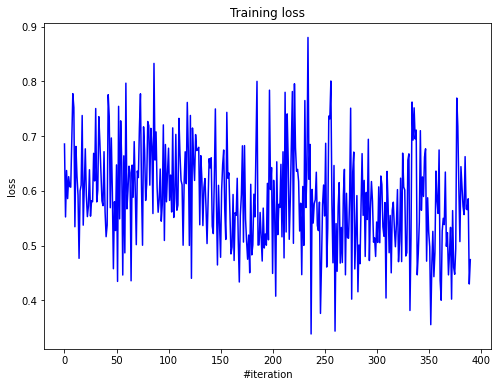

In [15]:
losses_with_bn_m = analyzation(opt_type = 'momentum', optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9})
losses_without_bn_m = analyzation(False, opt_type = 'momentum', optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9})

In [19]:
with open('losses_without_bn_m.pickle', 'wb') as fp:
    pickle.dump(losses_without_bn_m, fp)
    
with open('losses_with_bn_m.pickle', 'wb') as fp:
    pickle.dump(losses_with_bn_m, fp)

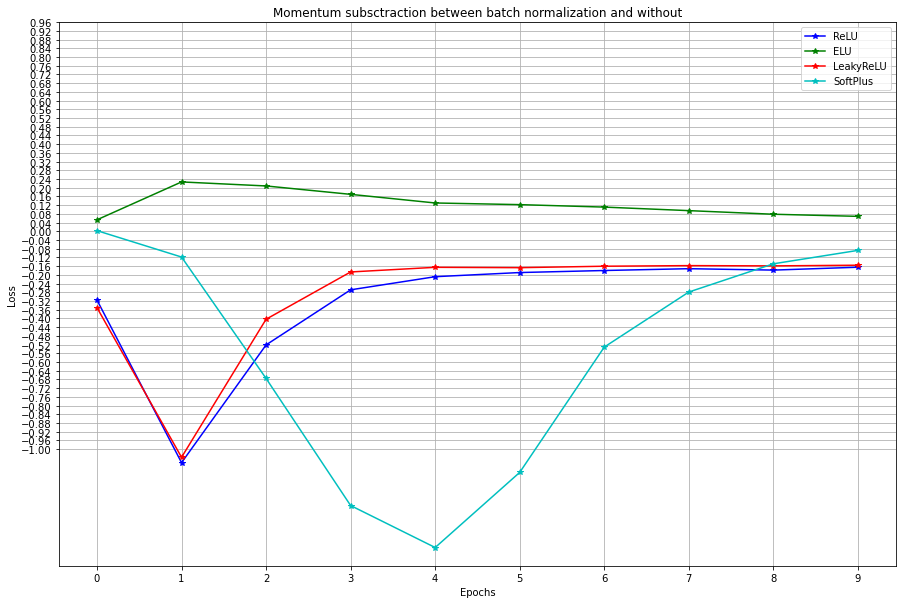

In [19]:
fig, ax = plt.subplots(figsize = (15, 10))
colors =  ['b', 'g', 'r', 'c']
colors_bn = ['m', 'y', 'k', 'w']
keys = losses_without_bn.keys()

for key, c in zip(keys, range(0, len(colors))):
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    y = np.array(losses_with_bn_m[key]) - np.array(losses_without_bn_m[key]) 
    ax.plot(y, f'{colors[c]}*-', label = key)

ax.set_title('Momentum subsctraction between batch normalization and without')
ax.legend()
ax.grid()
ax.set_xticks(range(0, 10))
ax.set_yticks(np.arange(-1, 1, step = 0.04))
pass

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

(Смотреть первые 2 графика с заглавиями "Adam subsctraction between batch normalization and without", "Momentum subsctraction between batch normalization and without")

Как мы  можем заметить, для данной модели сходимость на валидационных данных хуже без BatchNormalization чем с ним. При этом различие тем меньше, чем ближе к 10-й эпохе. Давайте посмотрим зависит ли это от типа оптимизации.
Как мы видим для momentum ситуация выглядит иным чем adam. При этом ситуация иная для ELU, а для SoftPlus разница  больше единицы, что интересно.

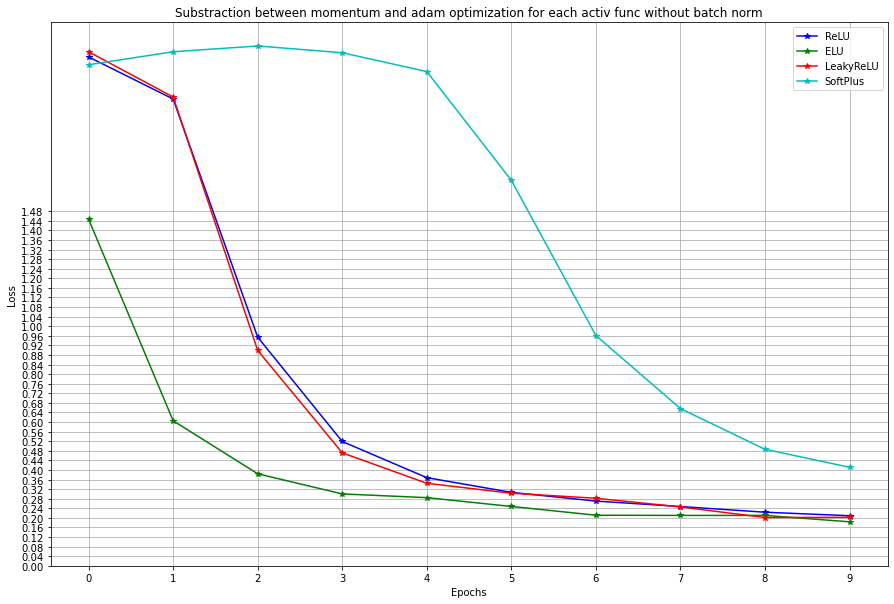

In [30]:
fig, ax = plt.subplots(figsize = (15, 10))
colors =  ['b', 'g', 'r', 'c']
colors_bn = ['m', 'y', 'k', 'w']
keys = losses_without_bn.keys()

for key, c in zip(keys, range(0, len(colors))):
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    y = np.array(losses_without_bn_m[key]) - np.array(losses_without_bn[key]) 
    ax.plot(y, f'{colors[c]}*-', label = key)

ax.set_title('Substraction between momentum and adam optimization for each activ func without batch norm')
ax.legend()
ax.grid()
ax.set_xticks(range(0, 10))
ax.set_yticks(np.arange(0, 1.5, step = 0.04))
pass

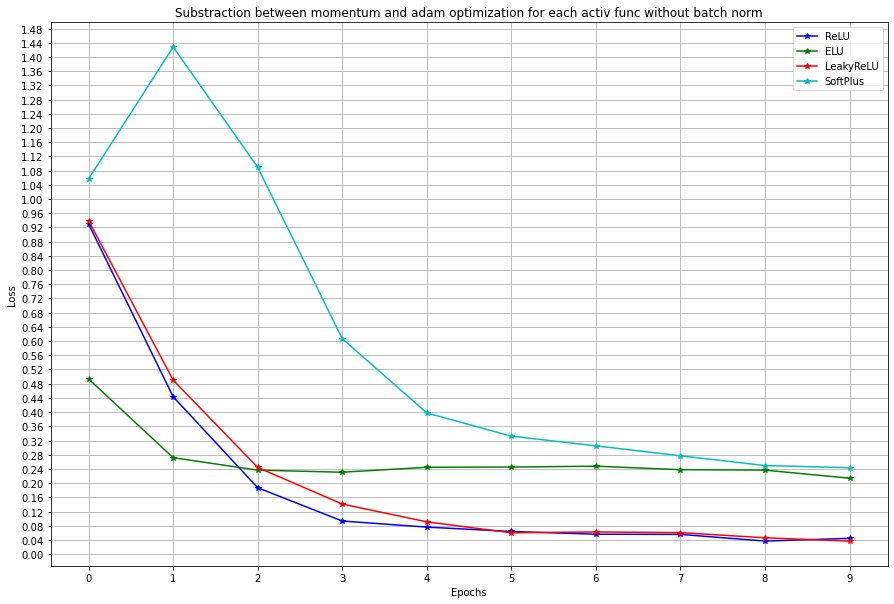

In [34]:
fig, ax = plt.subplots(figsize = (15, 10))
colors =  ['b', 'g', 'r', 'c']
colors_bn = ['m', 'y', 'k', 'w']
keys = losses_without_bn.keys()

for key, c in zip(keys, range(0, len(colors))):
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    y = np.array(losses_with_bn_m[key]) - np.array(losses_with_bn[key]) 
    ax.plot(y, f'{colors[c]}*-', label = key)

ax.set_title('Substraction between momentum and adam optimization for each activ func without batch norm')
ax.legend()
ax.grid()
ax.set_xticks(range(0, 10))
ax.set_yticks(np.arange(0, 1.5, step = 0.04))
pass

Как можно заметить, для данного типо сети momentum лучше, чем adam вне зависимости есть нормализация или нет. Видимо, это связано с архитектурой моей сети

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [31]:
from sklearn.metrics import accuracy_score

In [48]:
softmax = SoftMax()

In [111]:
def loop_epoch(net, X, Y, batch_size, optimizer = None, optimizer_config = None, optimizer_state = None, is_val = False):
    loss_history = []
    accuracy_history = []
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
        #accuracy
        y_target=np.argmax(y_batch,axis=-1)
        y_pred = np.argmax(softmax.updateOutput(predictions), axis = -1)
        accuracy = accuracy_score(y_target,y_pred)
        accuracy_history.append(accuracy)
        
        # Backward
        if not is_val:
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            # Update weights
            optimizer(net.getParameters(), 
                      net.getGradParameters(), 
                      optimizer_config,
                      optimizer_state)      
        
        loss_history.append(loss)
    return loss_history, accuracy_history

def loop(net, data_train, data_test, optimizer_config, optimizer_state,
         n_epoch = 10, batch_size = 128, is_val = False, opt_type = 'adam'):
    
    criterion = ClassNLLCriterion()
    plot_title = 'Validation loss' if is_val else 'Training loss'
    optimizers = {'adam': adam_optimizer, 'momentum': sgd_momentum}
    optimizer = optimizers[opt_type]
    
    X, Y = data_train
    X_val, Y_val = data_test
    loss_train_history=[]
    accuracy_train_history=[]
    loss_val_history = []
    accuracy_val_history = []
    for i in range(n_epoch):
        model.train()
        loss_history, accuracy_history = loop_epoch(net, X, Y, batch_size, optimizer, optimizer_config, optimizer_state)
        loss_train_history.extend(loss_history)
        accuracy_train_history.extend(accuracy_history)
        model.evaluate()
        loss_val, accuracy_val = loop_epoch(net, X_val, Y_val, batch_size, optimizer = optimizer, is_val = True)
        
        accuracy_val_mean = sum(accuracy_val)/len(accuracy_val)
        loss_val_mean = sum(loss_val)/len(loss_val)
        loss_val_history.append(loss_val_mean)
        accuracy_val_history.append(accuracy_val_mean)
        
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        plt.title(plot_title)
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_train_history, label = 'loss')
        plt.plot(accuracy_train_history, label = 'accuracy')
        plt.legend()
        plt.show()
        
    return loss_val_history, accuracy_val_history

In [112]:
optimizer_config = {'learning_rate' : 1e-3, 'beta1': 0.9,  'beta2': 0.999,  'epsilon': 1.e-08}
optimizer_state = {}

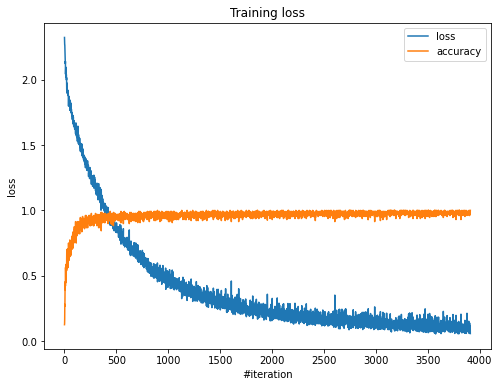

In [113]:
# Your code goes here. ################################################
in_features = X_train.shape[-1]
features = [in_features, 24*24, 20*20, 10]
model = Sequential()
for i in range(1, len(features)):
    model.add(Linear(features[i-1], features[i]))
    model.add(BatchNormalization())
    model.add(ChannelwiseScaling(features[i]))
    if i != len(features) - 1:
        model.add(LeakyReLU())
        model.add(Dropout(p=0.5))
    model.add(LogSoftMax())

loss_val_history,accuracy_history = loop(model, (X_train, y_train), (X_val, y_val), optimizer_config, optimizer_state)

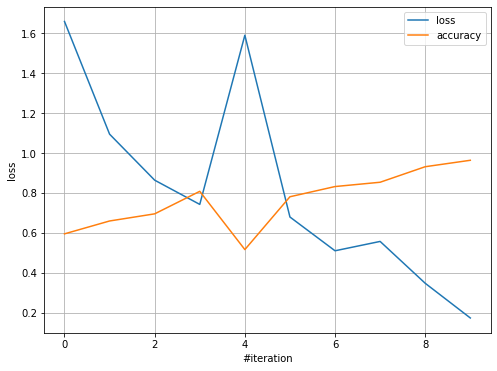

In [114]:
plt.figure(figsize=(8, 6))
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_val_history, label = 'loss')
plt.plot(accuracy_history, label = 'accuracy')
plt.grid()
plt.legend()
plt.show()

Print here your accuracy on test set. It should be around 90%.

In [115]:
# Your answer goes here. ################################################
model.evaluate()
loss_test, accuracy_test = loop_epoch(model, X_test, y_test, batch_size, is_val = True)
accuracy_test_mean = sum(accuracy_test)/len(accuracy_test)
loss_test_mean = sum(loss_test)/len(loss_test)

In [116]:
loss_test_mean,accuracy_test_mean

(0.1734013250663321, 0.9628164556962026)

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [93]:
import torch
from torch import nn
import torch.nn.functional as F 

In [104]:
# Your beautiful code here.
class ModelMNIST(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_shape, 24*24),
            nn.BatchNorm1d(24*24),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(24*24, 20*20),
            nn.BatchNorm1d(20*20),
            nn.Linear(20*20, 10),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return torch.nn.functional.log_softmax(out, dim = -1)

def loop(model, data, loss_func, opt = None, is_train = True, batch_size=128):
    acc_history = []
    history = []
    for image, y_target in get_batches(data, batch_size):
        
        image = torch.tensor(image)
        label = torch.tensor(y_target)
        
        x = image.reshape(image.shape[0], -1).to('cuda:0')
        logits = model(x)
        loss = loss_func(logits, label.to('cuda:0'))
        history.append(loss.detach().cpu().numpy())
        
        probas = F.softmax(logits, dim = -1)
        probas = probas.detach().cpu().numpy()
        y_pred = np.argmax(probas, axis = -1)
        current_acc = accuracy_score(np.argmax(y_target, axis = -1), y_pred)
        acc_history.append(current_acc)

        if is_train:
            loss.backward()
            opt.step()
            opt.zero_grad()
      
    mean_acc = np.array(acc_history).mean()
    mean_loss = np.array(history).mean()
    return mean_loss, mean_acc

In [105]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

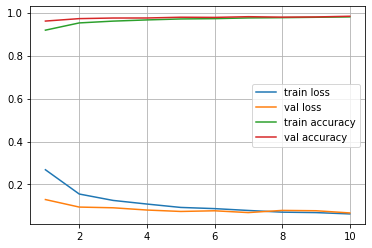

In [108]:
model = ModelMNIST().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()
epochs = 10

train_losses = []
test_losses = []
train_accs = []
test_accs = []
for i in range(10):
    train_loss, train_acc = loop(model, (X_train, y_train), loss_func, opt = opt)
    model.eval()
    with torch.no_grad():
        test_loss, test_acc = loop(model, (X_val, y_val), loss_func, is_train = False)
    model.train()
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if (i+1)%10 == 0:
        x = range(1, i+2, 1)

        display.clear_output(True)
        plt.plot(x, train_losses, label='train loss')
        plt.plot(x, test_losses, label='val loss')
        plt.plot(x, train_accs, label='train accuracy')
        plt.plot(x, test_accs, label='val accuracy')
        plt.grid()
        plt.legend()
        plt.show()

In [109]:
model.eval()
with torch.no_grad():
    test_loss, test_acc = loop(model, (X_test, y_test), loss_func, is_train = False)

In [110]:
test_loss,test_acc

(0.06274210544121746, 0.9804193037974683)